### In this project, we would explore regression analysis and make predictions on used car prices using an ensemble of regressors. After that, we would build a web app for user interactions and live predictions.
---
1. *In Part I of the project we pre-processed the data*
2. #### This is PART II of the project where we focus on regression methods and building an ensemble of them for used car prices prediction

#### Highlights of this part:
1.  Regression methods
2.  Building ensemble of regressors from scratch

**Citations:**

This dataset is from Kaggle - Used Cars Dataset

URL: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

---

The following description is from Kaggle:

**Context**

Craigslist is the world's largest collection of used vehicles for sale, yet it's very difficult to collect all of them in the same place. I built a scraper for a school project and expanded upon it later to create this dataset which includes every used vehicle entry within the United States on Craigslist.

**Content**

This data is scraped every few months, it contains most all relevant information that Craigslist provides on car sales including columns like price, condition, manufacturer, latitude/longitude, and 18 other categories. For ML projects, consider feature engineering on location columns such as long/lat. For previous listings, check older versions of the dataset.

See https://github.com/AustinReese1998/craigslistFilter

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Load dataset generated from Part I
df = pd.read_csv('Data/vehicles_pre-processed.csv')

In [4]:
df.head()

,price,year,manufacturer,model,fuel,odometer,title_status,transmission,state
0,10299,2012.0,acura,NaN,gas,90186.0,clean,automatic,nc
1,3995,2004.0,honda,NaN,gas,212526.0,clean,automatic,nc
2,12995,2015.0,kia,sportage,gas,85127.0,clean,automatic,nc
3,10995,2014.0,chevrolet,traverse,gas,112383.0,clean,automatic,nc
4,8995,2011.0,bmw,NaN,gas,124446.0,clean,automatic,nc


We could do some visualizations on the data, for example the following. I would create another demonstration solely on data visualizations. For now, let's focus on the objective of predicting used car prices.

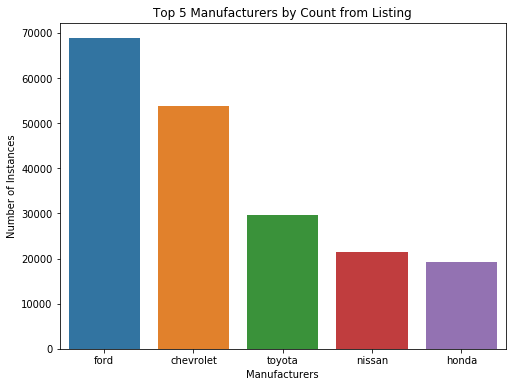

In [12]:
mc = df['manufacturer'].value_counts().head()
plt.figure(figsize = (8, 6))
sns.barplot(x = mc.index, y = mc.values)
plt.title('Top 5 Manufacturers by Count from Listing')
plt.xlabel('Manufacturers')
plt.ylabel('Number of Instances')
plt.show()